In [55]:
import scPhyloX as spx
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import poisson

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


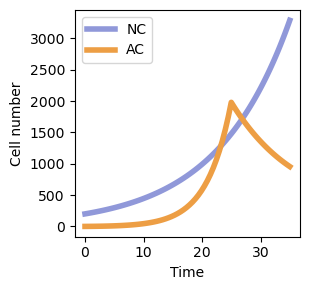

In [408]:
r, a, s, u = (0.4, 0.6, 0.2, 1e-2)
K = 35
x0 = [200, 0]
s1 = -0.2
t1 = 25
fig, ax = plt.subplots(1, 1, figsize=(3.2, 3))

sol = solve_ivp(spx.est_tumor.cellnumber, t_span=(0, t1), y0=x0, 
                method='RK45', t_eval=np.linspace(0, t1, 50), args=(r, a, s, u))

x01 = sol.y[:, -1]

sol1 = solve_ivp(spx.est_tumor.cellnumber, t_span=(0, K-t1+1), y0=x01, 
                method='RK45', t_eval=np.linspace(0, K-t1, 50), args=(r, a, s1, u))

sol_t = np.concatenate((sol.t, sol1.t+t1))
sol_y = np.concatenate((sol.y, sol1.y), axis=1)
ax.plot(sol_t, sol_y[0], label='NC', c='#9098d9', lw=4)
ax.plot(sol_t, sol_y[1], label='AC', c='#ed9e44', lw=4)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')

plt.tight_layout()

In [383]:
def simulation(x0, max_t, mut_rate, r, a, s, s1, u):
    num_elements = 2
    system = spx.sim_tumor.System(num_elements, inits = x0, max_t = max_t, mut_rate = mut_rate)
    
    birth_n = lambda t: r*a
    birth_a = lambda t: r*(a+s)*(t<t1)+r*(a+s1)*(t>=t1)
    diff = lambda t: r*u
    death_n = lambda t: r*(1-a-u)
    death_a = lambda t: r*(1-a-s)*(t<t1)+r*(1-a-s1)*(t>=t1)

    system.add_reaction(birth_n, [1, 0], [2, 0], 1)
    system.add_reaction(birth_a, [0, 1], [0, 2], 2)
    system.add_reaction(diff, [1, 0], [0, 1], 3)
    system.add_reaction(death_n, [1, 0], [0, 0], 4)
    system.add_reaction(death_a, [0, 1], [0, 0], 5)
    system.evolute(200000000)
    return system 

In [386]:
system = simulation(x0, K, mu, r, a, s, s1, u)

cell_num:3916, time:35.0000497616731254

Text(0, 0.5, 'Cell number')

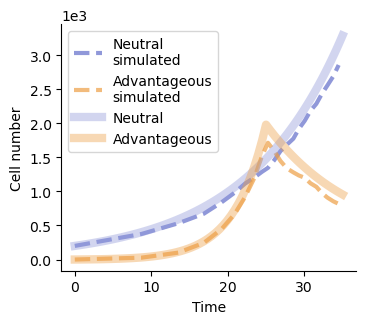

In [387]:
time = system.t
cell_number = np.array(system.n)
fig, ax = plt.subplots(figsize=(3.8, 3.2))
show_tp = np.arange(0, len(time),1000)
ax.plot(np.array(time)[np.arange(0, len(time),1000)], cell_number[np.arange(0, len(time),1000), 0], '--', lw=3, label='Neutral\nsimulated', c='#9098d9')
ax.plot(np.array(time)[np.arange(0, len(time),1000)], cell_number[np.arange(0, len(time),1000), 1], '--', lw=3, label='Advantageous\nsimulated', c='#ed9e44', alpha=0.7)
ax.plot(sol_t, sol_y[0], label='Neutral', c='#9098d9', lw=6, alpha=0.4)
ax.plot(sol_t, sol_y[1], label='Advantageous', c='#ed9e44', lw=6, alpha=0.4)
ax.legend(loc=2, fontsize=10)
ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')

In [388]:
import pickle
import gzip
data = {
            'NC':system.Neutral, 
            'AC':system.Advantageous,
            'cell_num':np.hstack([np.array(system.t).reshape(-1,1), np.array(system.n)]),
        }
pickle.dump(data, open(f'../datasets/treatment/treatment_{r=}_{a=}_{s=}_{u=}_{s1=}_{t1=}.pkl', 'wb'))

In [389]:
seqtab = np.array([i.seq for i in system.Neutral] + [i.seq for i in system.Advantageous])
seqtab = seqtab[np.random.choice(range(seqtab.shape[0]), 500, replace=False)]

In [390]:
branch_len = spx.data_factory.get_branchlen(seqtab)
mutnum = spx.data_factory.get_mutnum(seqtab)
ge = spx.est_mr.GenerationEst(mutnum, 2)
gen_num = ge.estimate(cell_number[-1].sum())

100%|██████████| 125250/125250 [00:03<00:00, 41674.44it/s]


In [391]:
def p_xi(gen, T, x0, r, a, s, u, t1, s1):
    '''
    Probability density function of LR distance
    Args:
        gen:
            generation
        T: 
            total time
        t1:
            treatment time
        s1:
            selection after treatment
        x0:
            initial cell number
        r, a, s, u: 
            parameters
    Return:
        np.array:
            Probability density of LR distance at time T.
    '''
    sol_nc = np.array([spx.est_tumor.nc_sol(T, x0, i, r, a) for i in range(gen)])
    sol_ac = solve_ivp(spx.est_tumor.cellnumber_ac, t_span=(0, T-t1), y0=[0]*gen, method='RK45', args=(x0, r, a, s, u)).y[:,-1]
    sol_ac = solve_ivp(spx.est_tumor.cellnumber_ac, t_span=(0, t1), y0=sol_ac, method='RK45', args=(x0, r, a, s1, u)).y[:,-1]
    cell_num = sol_nc+sol_ac
    return cell_num

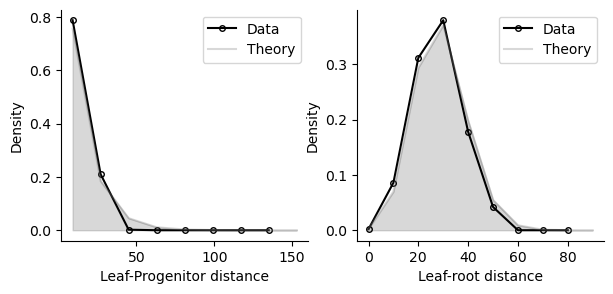

In [405]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
max_val = 150
n_hist = 8
xrange = np.arange(0, max_val, int(max_val/n_hist))+int(max_val/n_hist)/2
dist = np.histogram(branch_len+1, xrange-int(max_val/n_hist)/2)
th_dist = [spx.est_mr.BranchLength(2, 0.15).prob(i) for i in xrange]
ax[0].plot(xrange[:-1], dist[0]/sum(dist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[0].plot(xrange, th_dist/sum(th_dist), c='tab:grey',alpha=0.3, label='Theory')
ax[0].fill_between(xrange, th_dist/sum(th_dist), color='tab:grey', alpha=0.3)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Leaf-Progenitor distance')
ax[0].set_ylabel('Density')
ax[0].legend()


alpha = alpha = p_xi(100, K, 200, *[0.4, 0.6, 0.2, 1e-2, t1, s1])
alpha = alpha / sum(alpha)
max_val = 100
n_hist = 10
mutdist = np.histogram(mutnum, np.arange(0, max_val, int(max_val/n_hist)))
th_dist = np.zeros(max_val)
for i, aa in enumerate(alpha):
    th_dist = th_dist + aa*poisson(i*2).pmf(np.arange(max_val))
th_dist_x = []
th_dist_y = []
for i in range(n_hist):
    th_dist_x.append(i*int(max_val/n_hist))
    th_dist_y.append(np.sum(th_dist[i*int(max_val/n_hist):(i+1)*int(max_val/n_hist)]))
ax[1].plot(mutdist[1][:-1], mutdist[0]/sum(mutdist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[1].plot(th_dist_x, th_dist_y, c='tab:grey',alpha=0.3, label='Theory')
ax[1].fill_between(th_dist_x, th_dist_y, color='tab:grey', alpha=0.3)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('Leaf-root distance')
ax[1].set_ylabel('Density')
ax[1].legend()

In [406]:
import pymc as pm
import pytensor
import pytensor.tensor as pt
from scipy.stats import norm
import arviz as az
def my_loglike(theta, data, args):
    '''
    Likelihood of lr-dist

    Args:
        theta:
            parameters, (r, a, s, u, s1)
        data:
            Observed lr dist
        args:
            paramteres, (time, initial_cell_number, prior_sigma)
    Return:
        float:
            Sum of log-likelihood of given lr dist parameters
    '''
    T, t1, c0, sigma = args
    r, a, s, u, s1 = theta
    xt = p_xi(len(data), T, c0, r, a, s, u, t1, s1)
    llh = norm(xt, sigma).logpdf(data).sum()
    return llh

class LogLike(pt.Op):
    itypes = [pt.dvector]
    otypes = [pt.dscalar]

    def __init__(self, loglike, data, args):
        
        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.args = args

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables
 
        # call the log-likelihood function
        logl = self.likelihood(theta, self.data, self.args)

        outputs[0][0] = np.array(logl)  # output the log-likelihood
        
def mcmc_inference(data, para_prior, T, t1, c0, sigma, draw=1000, tune=1000, chains=5):
    '''
    Mutation rate estimation using DE-MCMC
    
    Args:
        data:
            Observed lp-dist
        data_prior:
            mean of prior distributions of all parameters
        T:
            time of phylodynamics eqns
        c0:
            initial cell numbers
        sigma:
            variation of loss function
        draw:
            Number of smaples to draw
        tune:
            Number of iterations to tune
        chain:
            number of chains to sample
    '''
    logl = LogLike(my_loglike, data, (T, t1, c0, sigma))
    rh, ah, sh, uh, s1h = para_prior
    with pm.Model() as model:
        r = pm.TruncatedNormal('r', mu=rh, sigma=0.1, lower=0, upper=5, initval=rh)
        a = pm.TruncatedNormal('a', mu=ah, sigma=0.1, lower=0.5, upper=1, initval=ah)
        s = pm.TruncatedNormal('s', mu=sh, sigma=0.1, lower=0, upper=0.5, initval=sh)
        s1 = pm.TruncatedNormal('s1', mu=s1h, sigma=0.1, lower=-0.5, upper=0.5, initval=s1h)
        u = pm.Beta('u', alpha=1, beta=1/uh-1, initval=uh)
        theta = pt.as_tensor_variable([r, a, s, u, s1])
        pm.Potential("likelihood", logl(theta))
        idata = pm.sample(draw, tune=tune, step=pm.DEMetropolis(), chains=chains)
    return idata



In [409]:
idata = mcmc_inference(gen_num, (r,a,s,u,s1), T=K, t1=t1, c0=200, sigma=100)

Population sampling (5 chains)
DEMetropolis: [r, a, s, s1, u]
/home/wangkun/miniconda3/lib/python3.9/site-packages/pymc/sampling/population.py:84: UserWarning: DEMetropolis should be used with more chains than dimensions! (The model has 5 dimensions.)
  warn_population_size(
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 196 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [410]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.381,0.014,0.357,0.410,0.001,0.001,281.0,509.0,1.01
a,0.610,0.005,0.600,0.621,0.000,0.000,321.0,311.0,1.02
s,0.188,0.045,0.103,0.276,0.005,0.004,92.0,159.0,1.06
s1,-0.184,0.072,-0.318,-0.046,0.004,0.003,407.0,621.0,1.01
u,0.007,0.006,0.000,0.017,0.001,0.000,169.0,119.0,1.06
